# Compute derivatives of the Prediction (on Omega or Omega_h)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

## Imports

In [2]:
import argparse

from scar.problem.Case import *
from scar.utils import read_config,create_tree
from scar.equations.run_Poisson2D import *

from scar.solver.solver_fem import FEMSolver
from scar.solver.solver_phifem import PhiFemSolver
from scar.correction.correct_pred import *

import torch
from torch.autograd import grad as grad_torch
import dolfin as df
from dolfin import FunctionSpace,Function

import matplotlib.pyplot as plt

Using device: cpu


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


## Define case

In [3]:
casefile = "case.json"
config = 1
derive = 1 # help="Order of the derivatives (1 or 2) ."
direction = "x" # help="Direction of the derivatives (x or y) ."

In [4]:
cas = Case("../testcases/"+casefile)

problem_considered = cas.problem
sdf_considered = cas.sd_function
pde_considered = cas.pde

dir_name = "../"+cas.dir_name
models_dir = dir_name+"models/"
derivees_dir = dir_name+"derivees/"
create_tree(derivees_dir)

## Récupération du modèle

### Config file :  ../networks/Poisson2D/Circle/SDCircle/WSolOnCircle/-0.1/models/config_1.json
### Model file :  ../networks/Poisson2D/Circle/SDCircle/WSolOnCircle/-0.1/models/model_1.pth
### Config  1  :  {'casefile': 'case.json', 'layers': [20, 20, 20, 20], 'activation': 'sine', 'lr': [0.01], 'decay': 0.99, 'w_data': 0.0, 'w_res': 1.0, 'n_epochs': 10000, 'n_collocations': 2000, 'n_data': 0}
Threshold of the sampling:  -0.1
Threshold of the sampling:  -0.1
Threshold of the sampling:  -0.1
Threshold of the sampling:  -0.1
>> load network /home/flecourtier/Bureau/Thèse/networks/Poisson2D/Circle/SDCircle/WSolOnCircle/-0.1/models/model_1.pth


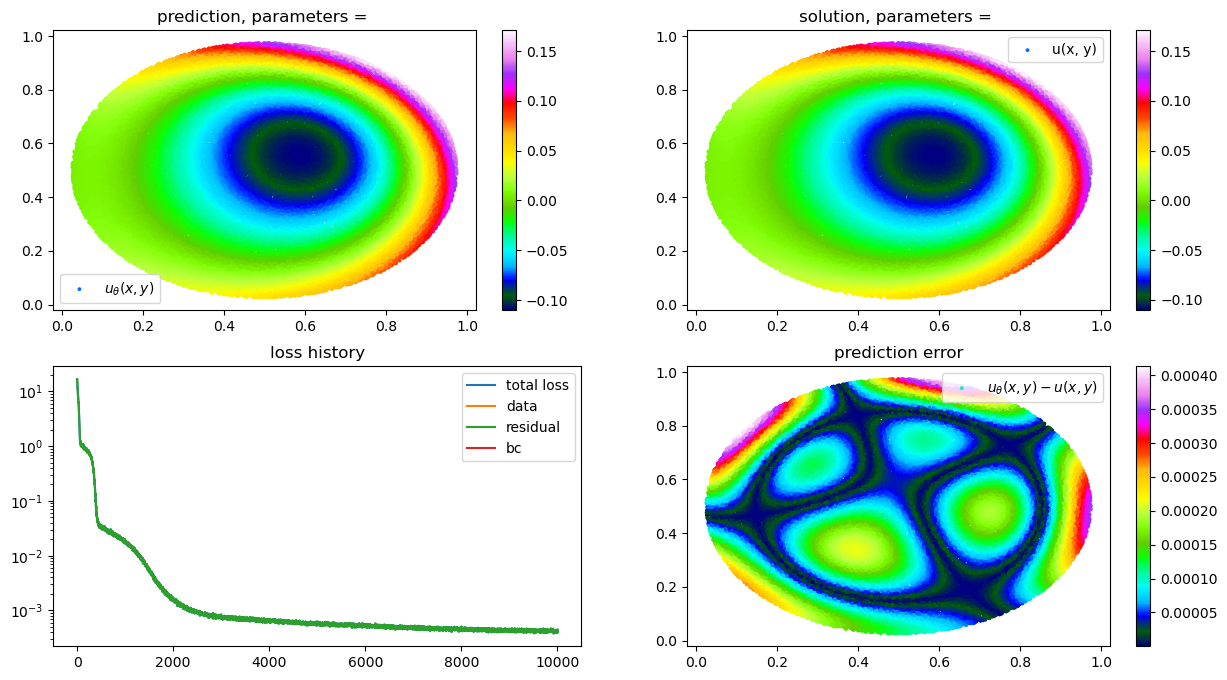

In [5]:
config_filename = models_dir+"config_"+str(config)+".json"
model_filename = models_dir+"model_"+str(config)+".pth"
print("### Config file : ",config_filename)
print("### Model file : ",model_filename)

dict = read_config(config_filename)
print("### Config ", config, " : ", dict)

trainer = run_Poisson2D(cas,config,dict)

## Dérivées

Compute derivatives :

In [6]:
def derivees_exactes(pre,XXYY,mu,derive,direction):
    if derive == 1:
        du_true_dx,du_true_dy = problem_considered.u_ex_prime(pre,XXYY,mu)
        if direction == "x":
            return du_true_dx
        elif direction == "y":
            return du_true_dy
        else:
            ValueError("direction = 'x' or 'y'")
    elif derive == 2: 
        du_true_dxx,du_true_dyy = problem_considered.u_ex_prime2(pre,XXYY,mu)
        if direction == "x":
            return du_true_dxx
        elif direction == "y":
            return du_true_dyy
        else:
            ValueError("direction = 'x' or 'y'")
    else:
        ValueError("derive = 1 or 2")

def derivees_torch(u_pred,x,derive,direction):
    first_derivatives = grad_torch(u_pred["w"].sum(), x, create_graph=True)[0]
    du_dx = first_derivatives[:, 0]
    du_dy = first_derivatives[:, 1]
    if derive == 1:
        if direction == "x":
            return du_dx
        elif direction == "y":
            return du_dy
        else:
            ValueError("direction = 'x' or 'y'")
    elif derive == 2: 
        if direction == "x":
            second_derivatives_x = grad_torch(du_dx.sum(), x, create_graph=True)[0]
            return second_derivatives_x[:, 0]
        elif direction == "y":
            second_derivatives_y = grad_torch(du_dy.sum(), x, create_graph=True)[0]
            return second_derivatives_y[:, 1]
        else:
            ValueError("direction = 'x' or 'y'")
    else:
        ValueError("derive = 1 or 2")

def derivees_FEniCS(phi_tild_FEniCS,V_phi,derive,direction):
    du_dx,du_dy = df.grad(phi_tild_FEniCS)
    if derive == 1:
        if direction == "x":
            return df.project(du_dx,V_phi)
        elif direction == "y":
            return df.project(du_dy,V_phi)
        else:
            ValueError("direction = 'x' or 'y'")
    elif derive == 2: 
        if direction == "x":
            du_dxx,du_dxy = df.grad(du_dx)
            return df.project(du_dxx,V_phi)
        elif direction == "y":
            du_dxy,du_dyy = df.grad(du_dy)
            return df.project(du_dyy,V_phi)
        else:
            ValueError("direction = 'x' or 'y'")
    else:
        ValueError("derive = 1 or 2")

In [7]:
if trainer.pde.nb_parameters == 0:
    params = [[None,None,None]]
else:
    mu = torch.mean(trainer.pde.parameter_domain, axis=1)
    S,f,p = mu.numpy()
    params = [[S,f,p]]

nb_vert = 32
deg_corr = 10

tab_derive = [1,2]
tab_direction = ["x","y"]

Plot :

In [8]:
def plot_derivatives(du_ex,du_pytorch,du_fenics,V_phi,config,domain,derive,direction):
    vmin = np.min(du_ex)
    vmax = np.max(du_ex)
    ticks = np.linspace(vmin,vmax,10)

    plt.figure(figsize=(15,10))
    if derive == 1:
        fig_title = "Dérivées premières selon "
    elif derive == 2:
        fig_title = "Dérivées secondes selon "
    plt.suptitle(fig_title+direction,fontsize=30)

    den = direction*derive

    plt.subplot(2,3,1)
    du_ex_FE = Function(V_phi)
    du_ex_FE.vector()[:] = du_ex.copy()
    c = df.plot(du_ex_FE, mode="color", vmin=vmin, vmax=vmax, title="du_ex_d"+den)
    plt.colorbar(c, ticks=ticks)
    plt.xlim(sdf_considered.bound_box[0])
    plt.ylim(sdf_considered.bound_box[1])

    #####
    # Pytorch
    #####

    plt.subplot(2,3,2)
    du_pytorch_FE = Function(V_phi)
    du_pytorch_FE.vector()[:] = du_pytorch.detach().numpy().copy()
    c = df.plot(du_pytorch_FE, mode="color", vmin=vmin, vmax=vmax, title="du_d"+den)
    plt.xlim(sdf_considered.bound_box[0])
    plt.ylim(sdf_considered.bound_box[1])
    plt.colorbar(c, ticks=ticks)
    plt.ylabel("PyTorch",fontsize=20)

    plt.subplot(2,3,3)
    error = abs(du_ex_FE-du_pytorch_FE)
    c = df.plot(error, title="|du_ex_d"+den+"-du_pytorch_d"+den+"|")
    plt.xlim(sdf_considered.bound_box[0])
    plt.ylim(sdf_considered.bound_box[1])
    plt.colorbar(c)

    #####
    # FEniCS
    #####

    plt.subplot(2,3,5)
    c = df.plot(du_fenics, mode="color", vmin=vmin, vmax=vmax, title="du_d"+den)
    plt.xlim(sdf_considered.bound_box[0])
    plt.ylim(sdf_considered.bound_box[1])
    plt.colorbar(c, ticks=ticks)
    plt.ylabel("FEniCS",fontsize=20)

    plt.subplot(2,3,6)
    error = abs(du_ex_FE-du_fenics)
    c = df.plot(error, title="|du_ex_d"+den+"-du_fenics_d"+den+"|")
    plt.xlim(sdf_considered.bound_box[0])
    plt.ylim(sdf_considered.bound_box[1])
    plt.colorbar(c)

    config_dir = derivees_dir+"config_"+str(config)+"/"
    create_tree(config_dir)
    plt.savefig(config_dir+"derivees_"+domain+"_"+den+".png")
    # plt.show()

### Sur $\Omega$

Get the PINNs prediction :

In [9]:
solver = FEMSolver(nb_cell=nb_vert-1, params=params, cas=cas)

# get coordinates of the dof
parameter_domain = trainer.pde.parameter_domain
V_phi,X_test,mu_test = get_test_sample(solver,parameter_domain,deg_corr)
XXYY = X_test.detach().numpy()

# get u_PINNs
pred = trainer.network.setup_w_dict(X_test, mu_test)
phi_tild = pred["w"][:,0].cpu().detach().numpy()
u_PINNs = Function(V_phi)
u_PINNs.vector()[:] = phi_tild.copy()

Compute derivatives :

In [10]:
for derive in tab_derive:
    for direction in tab_direction:
        # Dérivées exactes
        du_ex = derivees_exactes(np,XXYY.T,params[0],derive,direction)

        # Dérivées Torch
        du_pytorch = derivees_torch(pred,X_test,derive,direction)

        # Dérivées FEniCS
        du_fenics = derivees_FEniCS(u_PINNs,V_phi,derive,direction)

        plot_derivatives(du_ex,du_pytorch,du_fenics,V_phi,config,"Omega",derive,direction)
        plt.close('all')

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


### Sur $\Omega_h$

In [11]:
solver = PhiFemSolver(nb_cell=nb_vert-1, params=params, cas=cas)

# get coordinates of the dof
parameter_domain = trainer.pde.parameter_domain
V_phi,X_test,mu_test = get_test_sample(solver,parameter_domain,deg_corr)
XXYY = X_test.detach().numpy()

# get u_PINNs
pred = trainer.network.setup_w_dict(X_test, mu_test)
phi_tild = pred["w"][:,0].cpu().detach().numpy()
u_PINNs = Function(V_phi)
u_PINNs.vector()[:] = phi_tild.copy()

num of cell in the ghost penalty: 150


Compute derivatives :

In [12]:
for derive in tab_derive:
    for direction in tab_direction:
        # Dérivées exactes
        du_ex = derivees_exactes(np,XXYY.T,params[0],derive,direction)

        # Dérivées Torch
        du_pytorch = derivees_torch(pred,X_test,derive,direction)

        # Dérivées FEniCS
        du_fenics = derivees_FEniCS(u_PINNs,V_phi,derive,direction)

        plot_derivatives(du_ex,du_pytorch,du_fenics,V_phi,config,"Omega_h",derive,direction)
        plt.close('all')

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
